<a href="https://colab.research.google.com/github/Meralbalik/Capstone-Project-2/blob/master/Pneumonia_images_DCGAN_ChestXRay_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate Chest X-Ray Images using DCGAN

## Import the necessary libraries

In [1]:
import sys, os, glob, time, imageio 
import numpy as np, pandas as pd  

import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from IPython.display import HTML

from PIL import Image 

import torch 
import torchvision.utils as vutils 
import torchvision.transforms as transforms 

from keras import models, layers, optimizers 
from keras.models import Sequential 
from keras.preprocessing.image import array_to_img, img_to_array, load_img 

import tensorflow as tf 

Using TensorFlow backend.


In [2]:
# connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls '/content/drive/My Drive/Colab Notebooks/chest_xray/chest_xray/'

test  train  val


In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/chest_xray/chest_xray/'

In [0]:
# assigning variables with the proper file path for the training, validation and test set
train_dir = os.path.join(data_path, 'train')
val_dir = os.path.join(data_path, 'val')
test_dir = os.path.join(data_path, 'test')

In [0]:

# assigning variables with the proper file path for the normal and pneumonia images 
train_normal_dir = os.path.join(train_dir, 'NORMAL')  
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')  
val_normal_dir = os.path.join(val_dir, 'NORMAL') 
val_pneumonia_dir = os.path.join(val_dir, 'PNEUMONIA') 
test_normal_dir = os.path.join(test_dir, 'NORMAL')  
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

In [7]:
# looking at how many images there are in each directory
dir = [train_normal_dir, train_pneumonia_dir, val_normal_dir,
            val_pneumonia_dir, test_normal_dir, test_pneumonia_dir]
dir_name = ['train_normal_dir', 'train_pneumonia_dir', 'val_normal_dir',
            'val_pneumonia_dir', 'test_normal_dir', 'test_pneumonia_dir']
for name, dir in zip(dir_name, dir):
  num_of_images = len(os.listdir(dir))
  print ('Number of images in {}: {}'.format(name, num_of_images))

Number of images in train_normal_dir: 1354
Number of images in train_pneumonia_dir: 3875
Number of images in val_normal_dir: 8
Number of images in val_pneumonia_dir: 8
Number of images in test_normal_dir: 234
Number of images in test_pneumonia_dir: 390


Text(0.5, 1.0, 'Test set, Condition: Pneumonia')

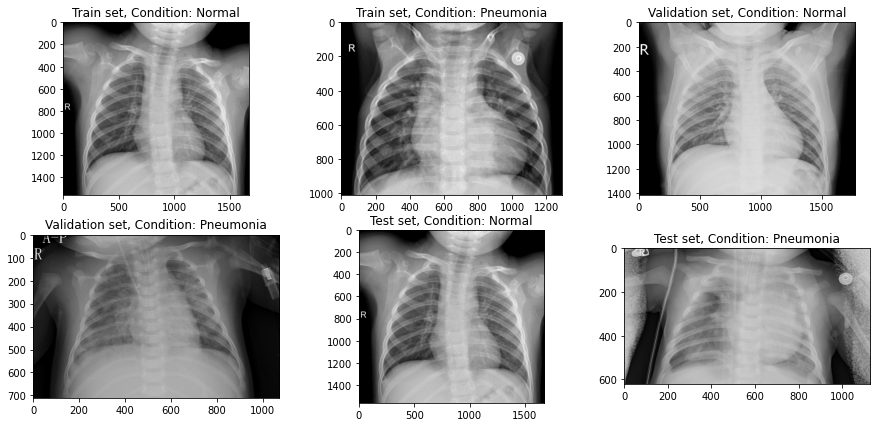

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
#plt.tight_layout()

ax[0].imshow(plt.imread(os.path.join(train_normal_dir, os.listdir(train_normal_dir)[0])), cmap='gray')
ax[0].set_title('Train set, Condition: Normal')
ax[1].imshow(plt.imread(os.path.join(train_pneumonia_dir, os.listdir(train_pneumonia_dir)[0])), cmap='gray')
ax[1].set_title('Train set, Condition: Pneumonia')
ax[2].imshow(plt.imread(os.path.join(val_normal_dir, os.listdir(val_normal_dir)[0])), cmap='gray')
ax[2].set_title('Validation set, Condition: Normal')
ax[3].imshow(plt.imread(os.path.join(val_pneumonia_dir, os.listdir(val_pneumonia_dir)[0])), cmap='gray')
ax[3].set_title('Validation set, Condition: Pneumonia')
ax[4].imshow(plt.imread(os.path.join(train_normal_dir, os.listdir(train_normal_dir)[0])), cmap='gray')
ax[4].set_title('Test set, Condition: Normal')
ax[5].imshow(plt.imread(os.path.join(test_pneumonia_dir, os.listdir(test_pneumonia_dir)[0])), cmap='gray')
ax[5].set_title('Test set, Condition: Pneumonia')

In [9]:
#normal_imgs = os.listdir(train_normal_dir) + os.listdir(val_normal_dir) + os.listdir(test_normal_dir)
#pneumonia_imgs = os.listdir(train_pneumonia_dir) + os.listdir(val_pneumonia_dir) + os.listdir(test_pneumonia_dir)

# Root paths for X-Ray images
normal_imgs  = glob.glob(data_path+'*/NORMAL/*.jpeg', recursive=True)
pneumonia_imgs = glob.glob(data_path+'*/PNEUMONIA/*.jpeg', recursive=True)

print('There are {} images in normal_imgs.'.format(len(normal_imgs)))
print('There are {} images in pneumonia_imgs.'.format(len(pneumonia_imgs)))

There are 1596 images in normal_imgs.
There are 4273 images in pneumonia_imgs.


In [0]:
def get_data(data_path, dim=(128, 128), rand_shuffle=True): 
    
    img_data = []         
    sample_size = len(data_path)
    for i, img in enumerate(data_path):
        if i % (sample_size//10)==0:
          print('Processing index {:05d} of {:05d} ==> {:03d}%'\
                  .format(i, sample_size, round(100*i/sample_size)))  
        img = img_to_array(load_img(img, target_size = dim)) 
        img_data.append(img) 
   
    # to float 
    img_data = np.array(img_data).astype('float32') 
    # scale to [0,1] (note the . after 255 - float)
    img_data = img_data/255. #for normalizing to [-1,1] ==> (imgs_data - 127.5)/127.5 
    
    # shuffle the data 
    if rand_shuffle: 
        i = np.arange(img_data.shape[0])
        np.random.shuffle(i) 
        img_data = img_data[i,:,:,:] 
    
    return img_data 

In [11]:
print('Starting for NORMAL X-Ray images ...')
X_normal = get_data(normal_imgs)
print()
print('Starting for PNEUMONIA X-Ray images ...')
X_pneumonia = get_data(pneumonia_imgs) 

Starting for NORMAL X-Ray images ...
Processing index 00000 of 01596 ==> 000%
Processing index 00159 of 01596 ==> 010%
Processing index 00318 of 01596 ==> 020%
Processing index 00477 of 01596 ==> 030%
Processing index 00636 of 01596 ==> 040%
Processing index 00795 of 01596 ==> 050%
Processing index 00954 of 01596 ==> 060%
Processing index 01113 of 01596 ==> 070%
Processing index 01272 of 01596 ==> 080%
Processing index 01431 of 01596 ==> 090%
Processing index 01590 of 01596 ==> 100%

Starting for PNEUMONIA X-Ray images ...
Processing index 00000 of 04273 ==> 000%
Processing index 00427 of 04273 ==> 010%
Processing index 00854 of 04273 ==> 020%
Processing index 01281 of 04273 ==> 030%
Processing index 01708 of 04273 ==> 040%
Processing index 02135 of 04273 ==> 050%
Processing index 02562 of 04273 ==> 060%
Processing index 02989 of 04273 ==> 070%
Processing index 03416 of 04273 ==> 080%
Processing index 03843 of 04273 ==> 090%
Processing index 04270 of 04273 ==> 100%


In [12]:
def define_grid(data_images, nrows=3, ncols=4, plot_grid=True):
    
    # Number of GPUs available. Use 0 for CPU mode. 
    ngpu = 1 
    # Decide which device we want to run on 
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    # Rearange the shape of the data 
    data_transp = [np.transpose(data_images[i,:,:]) for i in range(data_images[:nrows*ncols].shape[0])]
    # From to torch type for the grid 
    data_transp = torch.Tensor(data_transp)
    print(f'The shape is reordered from {data_images.shape[1:]} to {data_transp.shape[1:]}')
    
    # Make the grid 
    grid_images = np.transpose(
        vutils.make_grid(
            data_transp.to(device)[:nrows*ncols], 
            nrow = nrows,
            padding = 2,
            normalize = True,
            scale_each = True,
            pad_value = 1,
        ).cpu(), axes = (2,1,0))
        
    # Show the output grid 
    if plot_grid:
        plt.figure(figsize=(12,12)) 
        plt.axis("off") 
        plt.title(f'Grid of {nrows*ncols} real images', fontsize=27)
        plt.imshow(grid_images)
        
    return grid_images

grid_X_normal = define_grid(X_normal, plot_grid=False)
grid_X_pneumonia = define_grid(X_pneumonia, plot_grid=False)

The shape is reordered from (128, 128, 3) to torch.Size([3, 128, 128])
The shape is reordered from (128, 128, 3) to torch.Size([3, 128, 128])


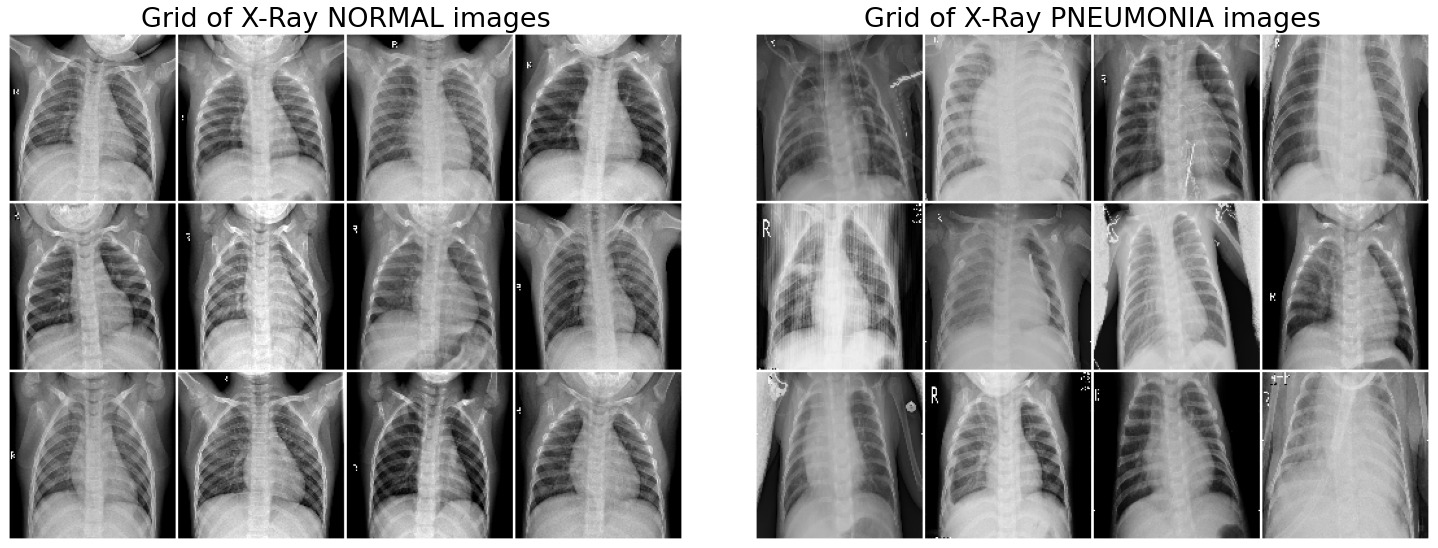

In [13]:
fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(19, 8))

ax1.imshow(grid_X_normal); ax1.axis('off')
ax1.set_title(label = 'Grid of X-Ray NORMAL images', fontsize = 27)

ax2.imshow(grid_X_pneumonia); ax2.axis('off')
ax2.set_title(label = 'Grid of X-Ray PNEUMONIA images', fontsize = 27)

plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=[0, 0.03, 1.1, 0.95])

## Set the parameters

In [0]:
# Number of training epochs
n_epoch = 200 

# Batch size during training 
batch_size = 128 

# Size of z latent vector (i.e. size of generator input) 
latent_dim = 100 

# Spatial size of training images. All images will be resized to this size 
cols, rows = 128, 128 

# Number of channels in the training images. For RGB color images this is 3
channels = 3 
dim = cols, rows # height, width 
in_shape = (cols, rows, channels) # height, width, color 

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1 

# plot ncols images in row and nrows images in colomn
nrows, ncols = 3, 4

## Discriminator

In [0]:
def define_discriminator(in_shape=(128,128,3)): 
    model = models.Sequential() 
    # normal 
    model.add(layers.Conv2D(128, (5,5), padding='same', input_shape=in_shape)) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 64x64 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 32x32 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 16x16 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # downsample to 8x8 
    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same')) 
    model.add(layers.LeakyReLU(alpha=0.2)) 
    # classifier 
    model.add(layers.Flatten()) 
    model.add(layers.Dropout(0.4)) 
    model.add(layers.Dense(1, activation='sigmoid')) 
    # compile model 
    opt = optimizers.Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) 
    return model

## Generator

In [0]:
def define_generator(latent_dim):
    model = models.Sequential()
    # foundation for 8x8 feature maps
    n_nodes = 128*8*8
    model.add(layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((8, 8, 128)))
    # upsample to 16x16
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 32x32
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 64x64
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # upsample to 128x128
    model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # output layer 128x128x3
    model.add(layers.Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model 

In [0]:
#input of G
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim*n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input 

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

## Define GAN model

In [0]:
def define_gan(g_model, d_model): 
    # make weights in the discriminator not trainable
    d_model.trainable = False 
    # connect them
    model = models.Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = optimizers.Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [0]:
# retrive real samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # set 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y


In [0]:
# create and save a plot of generated images 
def show_generated(generated, epoch, nrows=4, ncols=5):
    #[-1,1] -> [0,1] 
    #generated = (generated+1)/2 
    #generated = (generated[:ncols*nrows]*127.5)+127.5 
    #generated = generated*255 
    plt.figure(figsize=(10,10)) 
    for idx in range(nrows*ncols): 
        plt.subplot(nrows, ncols, idx+1) 
        plt.imshow(generated[idx]) 
        plt.axis('off') 
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1)) 
    plt.show() 

In [0]:
# evaluate the discriminator and plot generated images 
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples 
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples 
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples 
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance 
    print('> Accuracy at epoch %d [real: %.0f%%, fake: %.0f%%]'%(epoch+1, acc_real*100, acc_fake*100))
    # show plot 
    show_generated(x_fake, epoch) 

In [0]:
def plot_loss(loss):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training", fontsize=20) 
    plt.plot(loss[0], label="D_real") 
    plt.plot(loss[1], label="D_fake") 
    plt.plot(loss[2], label="G") 
    plt.xlabel("Iteration", fontsize=20); plt.ylabel("Loss", fontsize=20) 
    plt.legend(); plt.show() 

## Train the models

In [0]:
def train(g_model, d_model, gan_model, dataset, latent_dim=100, n_epochs=100, n_batch=128):
    
    bat_per_epo = int(dataset.shape[0]/n_batch) 
    half_batch = int(n_batch/2) 
    loss1, loss2, loss3 = [], [], [] 
    fake_liste = [] 
    
    # manually enumerate epochs
    print('Training Start...')
    for i in range(n_epochs):
        
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            loss1.append(d_loss1); loss2.append(d_loss2); loss3.append(g_loss) 

        print('Epoch: {:03d}/{:03d}, Loss: [D_real = {:2.3f}, D_fake = {:2.3f}, G = {:2.3f}]'\
              .format(i+1,n_epochs,d_loss1,d_loss2,g_loss))
        # evaluate the model performance 
        if (i+1)%(n_epochs//10) == 0: 
            # Save and show generated images 
            summarize_performance(i, g_model, d_model, dataset, latent_dim) 
    
    # Show loss curves 
    loss = (loss1, loss2, loss3) 
    plot_loss(loss)    

In [0]:
discriminator = define_discriminator() 
generator = define_generator(latent_dim) 

# create the gan 
gan = define_gan(generator, discriminator)

Training Start...


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 001/200, Loss: [D_real = 0.078, D_fake = 0.740, G = 0.740]
Epoch: 002/200, Loss: [D_real = 0.039, D_fake = 0.961, G = 0.942]
Epoch: 003/200, Loss: [D_real = 0.594, D_fake = 0.368, G = 1.868]
Epoch: 004/200, Loss: [D_real = 0.409, D_fake = 0.465, G = 1.550]
Epoch: 005/200, Loss: [D_real = 0.455, D_fake = 1.013, G = 1.871]
Epoch: 006/200, Loss: [D_real = 0.510, D_fake = 0.523, G = 2.113]
Epoch: 007/200, Loss: [D_real = 0.427, D_fake = 0.479, G = 1.798]
Epoch: 008/200, Loss: [D_real = 0.754, D_fake = 0.591, G = 2.021]
Epoch: 009/200, Loss: [D_real = 0.531, D_fake = 0.591, G = 1.854]
Epoch: 010/200, Loss: [D_real = 0.578, D_fake = 0.567, G = 1.626]
Epoch: 011/200, Loss: [D_real = 0.513, D_fake = 0.521, G = 1.568]
Epoch: 012/200, Loss: [D_real = 0.564, D_fake = 0.424, G = 2.207]
Epoch: 013/200, Loss: [D_real = 0.503, D_fake = 0.430, G = 1.818]
Epoch: 014/200, Loss: [D_real = 0.347, D_fake = 0.465, G = 2.024]
Epoch: 015/200, Loss: [D_real = 0.358, D_fake = 0.498, G = 2.012]
Epoch: 016

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 20 [real: 85%, fake: 98%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

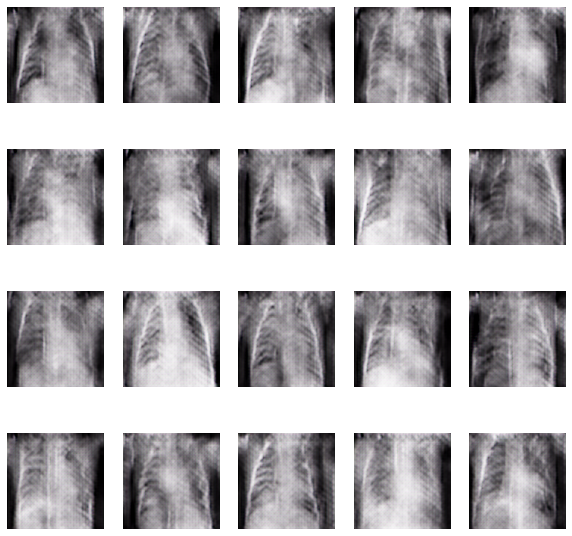

Epoch: 021/200, Loss: [D_real = 0.633, D_fake = 0.747, G = 2.700]
Epoch: 022/200, Loss: [D_real = 0.415, D_fake = 0.282, G = 3.208]
Epoch: 023/200, Loss: [D_real = 0.273, D_fake = 0.261, G = 2.881]
Epoch: 024/200, Loss: [D_real = 0.536, D_fake = 0.524, G = 2.666]
Epoch: 025/200, Loss: [D_real = 0.327, D_fake = 0.360, G = 2.817]
Epoch: 026/200, Loss: [D_real = 0.262, D_fake = 0.407, G = 3.665]
Epoch: 027/200, Loss: [D_real = 0.414, D_fake = 0.280, G = 3.217]
Epoch: 028/200, Loss: [D_real = 0.443, D_fake = 0.526, G = 4.177]
Epoch: 029/200, Loss: [D_real = 0.333, D_fake = 0.283, G = 3.811]
Epoch: 030/200, Loss: [D_real = 0.450, D_fake = 0.333, G = 2.944]
Epoch: 031/200, Loss: [D_real = 0.698, D_fake = 0.402, G = 3.160]
Epoch: 032/200, Loss: [D_real = 0.472, D_fake = 0.311, G = 2.754]
Epoch: 033/200, Loss: [D_real = 0.532, D_fake = 0.574, G = 2.822]
Epoch: 034/200, Loss: [D_real = 0.536, D_fake = 0.329, G = 2.440]
Epoch: 035/200, Loss: [D_real = 0.412, D_fake = 0.351, G = 2.635]
Epoch: 036

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 40 [real: 89%, fake: 98%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


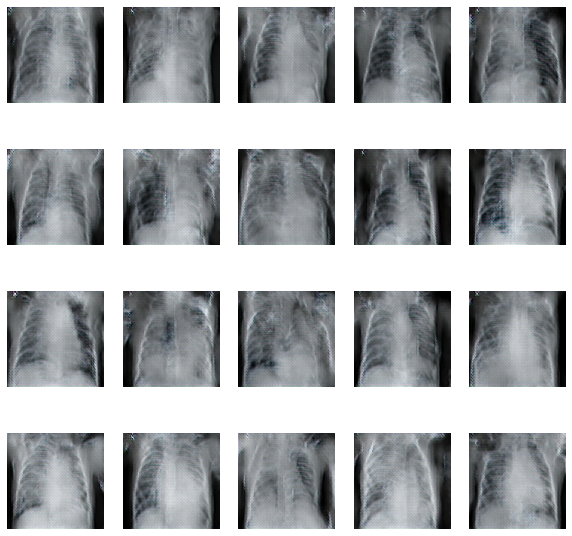

Epoch: 041/200, Loss: [D_real = 0.346, D_fake = 0.273, G = 3.137]
Epoch: 042/200, Loss: [D_real = 0.246, D_fake = 0.226, G = 2.847]
Epoch: 043/200, Loss: [D_real = 10.525, D_fake = 3.459, G = 4.053]
Epoch: 044/200, Loss: [D_real = 0.035, D_fake = 0.179, G = 4.684]
Epoch: 045/200, Loss: [D_real = 0.975, D_fake = 0.945, G = 1.864]
Epoch: 046/200, Loss: [D_real = 0.376, D_fake = 0.708, G = 1.902]
Epoch: 047/200, Loss: [D_real = 0.324, D_fake = 0.290, G = 2.151]
Epoch: 048/200, Loss: [D_real = 0.267, D_fake = 0.297, G = 2.582]
Epoch: 049/200, Loss: [D_real = 0.445, D_fake = 0.349, G = 2.320]
Epoch: 050/200, Loss: [D_real = 0.327, D_fake = 0.257, G = 2.534]
Epoch: 051/200, Loss: [D_real = 0.359, D_fake = 0.203, G = 2.417]
Epoch: 052/200, Loss: [D_real = 0.944, D_fake = 0.492, G = 2.050]
Epoch: 053/200, Loss: [D_real = 0.400, D_fake = 0.277, G = 2.221]
Epoch: 054/200, Loss: [D_real = 0.300, D_fake = 0.248, G = 2.330]
Epoch: 055/200, Loss: [D_real = 0.303, D_fake = 0.334, G = 2.252]
Epoch: 05

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 60 [real: 79%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


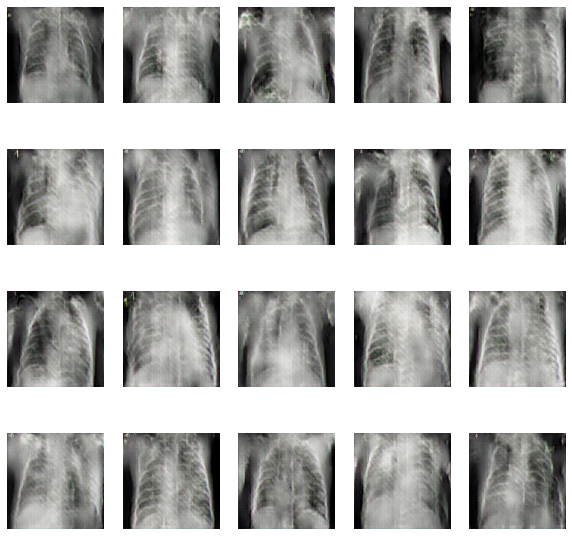

Epoch: 061/200, Loss: [D_real = 0.517, D_fake = 0.284, G = 2.049]
Epoch: 062/200, Loss: [D_real = 0.395, D_fake = 0.276, G = 2.170]
Epoch: 063/200, Loss: [D_real = 0.333, D_fake = 0.192, G = 2.463]
Epoch: 064/200, Loss: [D_real = 0.401, D_fake = 0.224, G = 2.417]
Epoch: 065/200, Loss: [D_real = 0.625, D_fake = 0.249, G = 2.129]
Epoch: 066/200, Loss: [D_real = 0.225, D_fake = 0.256, G = 2.301]
Epoch: 067/200, Loss: [D_real = 0.506, D_fake = 0.315, G = 2.395]
Epoch: 068/200, Loss: [D_real = 0.448, D_fake = 0.257, G = 2.653]
Epoch: 069/200, Loss: [D_real = 0.350, D_fake = 0.318, G = 2.365]
Epoch: 070/200, Loss: [D_real = 0.301, D_fake = 0.359, G = 2.593]
Epoch: 071/200, Loss: [D_real = 0.429, D_fake = 0.365, G = 1.952]
Epoch: 072/200, Loss: [D_real = 0.340, D_fake = 0.211, G = 2.635]
Epoch: 073/200, Loss: [D_real = 0.442, D_fake = 0.222, G = 2.373]
Epoch: 074/200, Loss: [D_real = 0.347, D_fake = 0.200, G = 2.552]
Epoch: 075/200, Loss: [D_real = 0.279, D_fake = 0.277, G = 2.392]
Epoch: 076

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 80 [real: 87%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

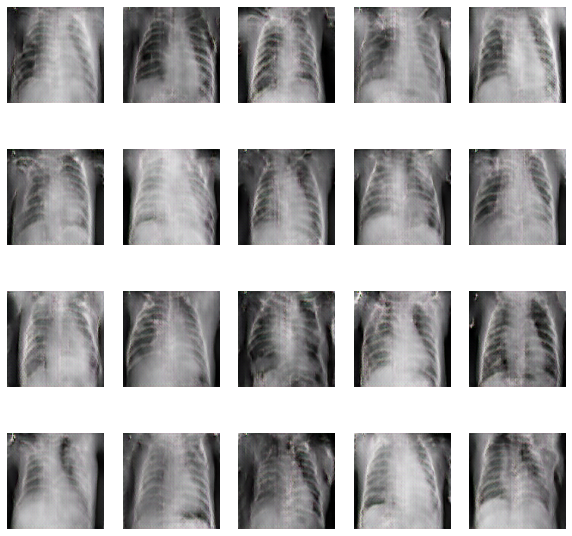

Epoch: 081/200, Loss: [D_real = 0.402, D_fake = 0.223, G = 2.308]
Epoch: 082/200, Loss: [D_real = 0.310, D_fake = 0.263, G = 2.883]
Epoch: 083/200, Loss: [D_real = 0.336, D_fake = 0.254, G = 2.942]
Epoch: 084/200, Loss: [D_real = 0.345, D_fake = 0.229, G = 2.725]
Epoch: 085/200, Loss: [D_real = 0.312, D_fake = 0.169, G = 2.882]
Epoch: 086/200, Loss: [D_real = 0.564, D_fake = 0.307, G = 2.544]
Epoch: 087/200, Loss: [D_real = 0.256, D_fake = 0.347, G = 3.021]
Epoch: 088/200, Loss: [D_real = 0.404, D_fake = 0.202, G = 2.583]
Epoch: 089/200, Loss: [D_real = 0.232, D_fake = 0.185, G = 3.177]
Epoch: 090/200, Loss: [D_real = 0.143, D_fake = 0.186, G = 3.198]
Epoch: 091/200, Loss: [D_real = 0.330, D_fake = 0.141, G = 2.851]
Epoch: 092/200, Loss: [D_real = 0.346, D_fake = 0.279, G = 3.239]
Epoch: 093/200, Loss: [D_real = 0.338, D_fake = 0.197, G = 2.740]
Epoch: 094/200, Loss: [D_real = 0.202, D_fake = 0.253, G = 3.010]
Epoch: 095/200, Loss: [D_real = 0.129, D_fake = 0.152, G = 3.209]
Epoch: 096

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 100 [real: 87%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

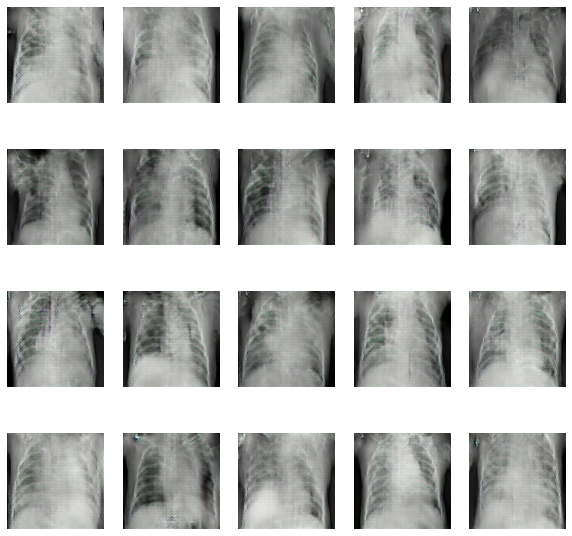

Epoch: 101/200, Loss: [D_real = 0.244, D_fake = 0.180, G = 3.052]
Epoch: 102/200, Loss: [D_real = 0.389, D_fake = 0.491, G = 2.903]
Epoch: 103/200, Loss: [D_real = 0.256, D_fake = 0.184, G = 3.511]
Epoch: 104/200, Loss: [D_real = 0.227, D_fake = 0.165, G = 3.347]
Epoch: 105/200, Loss: [D_real = 1.250, D_fake = 0.391, G = 1.704]
Epoch: 106/200, Loss: [D_real = 0.135, D_fake = 0.083, G = 3.498]
Epoch: 107/200, Loss: [D_real = 0.353, D_fake = 0.208, G = 2.897]
Epoch: 108/200, Loss: [D_real = 0.197, D_fake = 0.106, G = 3.046]
Epoch: 109/200, Loss: [D_real = 0.235, D_fake = 0.107, G = 3.354]
Epoch: 110/200, Loss: [D_real = 0.164, D_fake = 0.174, G = 3.158]
Epoch: 111/200, Loss: [D_real = 0.530, D_fake = 0.625, G = 4.595]
Epoch: 112/200, Loss: [D_real = 0.415, D_fake = 0.176, G = 2.738]
Epoch: 113/200, Loss: [D_real = 0.336, D_fake = 0.300, G = 3.170]
Epoch: 114/200, Loss: [D_real = 0.171, D_fake = 0.080, G = 3.240]
Epoch: 115/200, Loss: [D_real = 0.228, D_fake = 0.150, G = 3.559]
Epoch: 116

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 120 [real: 89%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


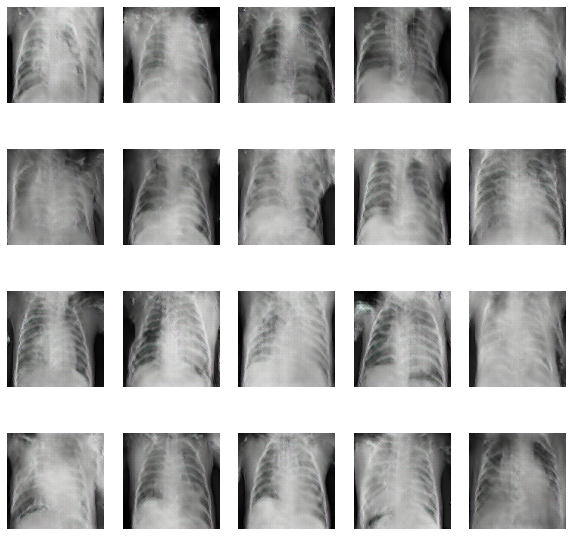

Epoch: 121/200, Loss: [D_real = 0.225, D_fake = 0.151, G = 3.301]
Epoch: 122/200, Loss: [D_real = 0.130, D_fake = 0.265, G = 3.838]
Epoch: 123/200, Loss: [D_real = 0.231, D_fake = 0.203, G = 3.729]
Epoch: 124/200, Loss: [D_real = 0.096, D_fake = 0.222, G = 4.016]
Epoch: 125/200, Loss: [D_real = 0.330, D_fake = 0.216, G = 2.929]
Epoch: 126/200, Loss: [D_real = 0.270, D_fake = 0.253, G = 3.208]
Epoch: 127/200, Loss: [D_real = 0.206, D_fake = 0.181, G = 4.288]
Epoch: 128/200, Loss: [D_real = 0.211, D_fake = 0.251, G = 3.060]
Epoch: 129/200, Loss: [D_real = 0.373, D_fake = 0.157, G = 3.068]
Epoch: 130/200, Loss: [D_real = 0.237, D_fake = 0.212, G = 3.081]
Epoch: 131/200, Loss: [D_real = 0.482, D_fake = 0.349, G = 2.703]
Epoch: 132/200, Loss: [D_real = 0.208, D_fake = 0.189, G = 3.624]
Epoch: 133/200, Loss: [D_real = 0.231, D_fake = 0.199, G = 2.752]
Epoch: 134/200, Loss: [D_real = 0.222, D_fake = 0.183, G = 4.115]
Epoch: 135/200, Loss: [D_real = 0.104, D_fake = 0.149, G = 3.742]
Epoch: 136

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 140 [real: 92%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


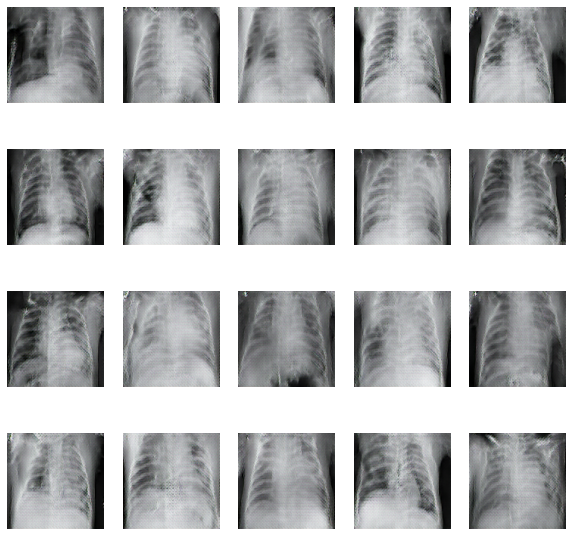

Epoch: 141/200, Loss: [D_real = 0.095, D_fake = 0.040, G = 3.959]
Epoch: 142/200, Loss: [D_real = 0.194, D_fake = 0.230, G = 3.991]
Epoch: 143/200, Loss: [D_real = 0.243, D_fake = 0.093, G = 3.477]
Epoch: 144/200, Loss: [D_real = 0.234, D_fake = 0.429, G = 5.008]
Epoch: 145/200, Loss: [D_real = 0.171, D_fake = 0.166, G = 4.378]
Epoch: 146/200, Loss: [D_real = 0.173, D_fake = 0.045, G = 3.968]
Epoch: 147/200, Loss: [D_real = 0.252, D_fake = 0.218, G = 4.257]
Epoch: 148/200, Loss: [D_real = 0.532, D_fake = 0.432, G = 2.118]
Epoch: 149/200, Loss: [D_real = 0.254, D_fake = 0.152, G = 3.036]
Epoch: 150/200, Loss: [D_real = 0.223, D_fake = 0.182, G = 4.193]
Epoch: 151/200, Loss: [D_real = 0.132, D_fake = 0.137, G = 3.510]
Epoch: 152/200, Loss: [D_real = 0.059, D_fake = 0.025, G = 4.866]
Epoch: 153/200, Loss: [D_real = 0.253, D_fake = 0.427, G = 4.279]
Epoch: 154/200, Loss: [D_real = 0.249, D_fake = 0.233, G = 4.015]
Epoch: 155/200, Loss: [D_real = 0.198, D_fake = 0.117, G = 3.494]
Epoch: 156

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

> Accuracy at epoch 160 [real: 85%, fake: 100%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


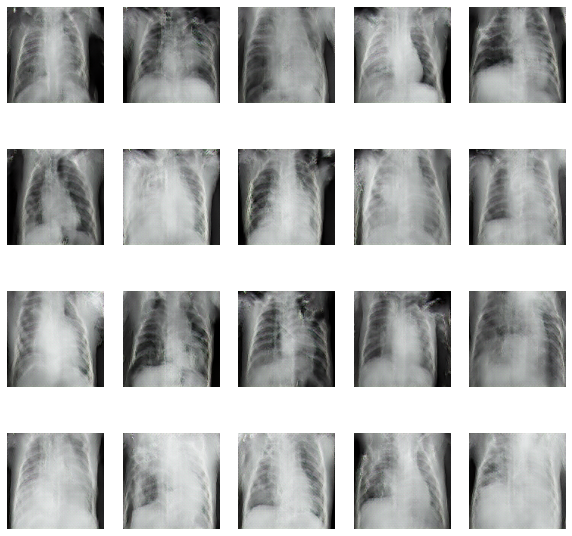

Epoch: 161/200, Loss: [D_real = 0.187, D_fake = 0.193, G = 4.210]
Epoch: 162/200, Loss: [D_real = 0.203, D_fake = 0.238, G = 4.296]
Epoch: 163/200, Loss: [D_real = 0.098, D_fake = 0.070, G = 4.144]
Epoch: 164/200, Loss: [D_real = 0.165, D_fake = 0.083, G = 4.270]
Epoch: 165/200, Loss: [D_real = 0.128, D_fake = 0.099, G = 3.739]
Epoch: 166/200, Loss: [D_real = 0.132, D_fake = 0.065, G = 4.182]
Epoch: 167/200, Loss: [D_real = 0.330, D_fake = 0.182, G = 3.756]
Epoch: 168/200, Loss: [D_real = 0.271, D_fake = 0.073, G = 3.926]
Epoch: 169/200, Loss: [D_real = 0.236, D_fake = 0.099, G = 4.235]
Epoch: 170/200, Loss: [D_real = 0.131, D_fake = 0.093, G = 3.978]
Epoch: 171/200, Loss: [D_real = 0.334, D_fake = 0.064, G = 3.500]
Epoch: 172/200, Loss: [D_real = 0.190, D_fake = 0.101, G = 3.712]
Epoch: 173/200, Loss: [D_real = 0.103, D_fake = 0.116, G = 4.496]
Epoch: 174/200, Loss: [D_real = 0.424, D_fake = 0.042, G = 3.989]
Epoch: 175/200, Loss: [D_real = 0.144, D_fake = 0.164, G = 4.257]
Epoch: 176

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 180 [real: 94%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


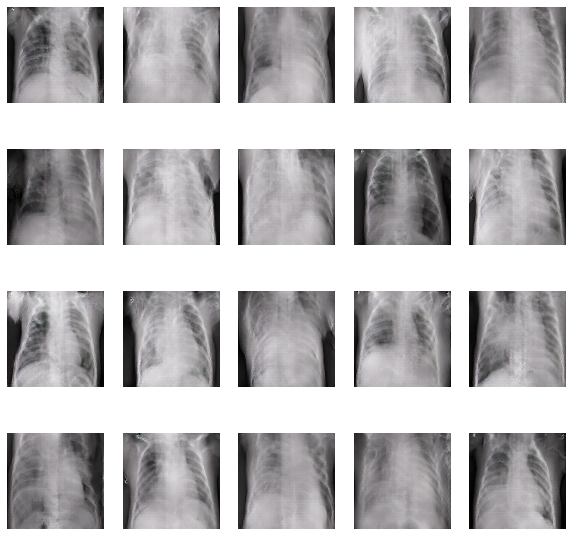

Epoch: 181/200, Loss: [D_real = 0.043, D_fake = 0.078, G = 4.384]
Epoch: 182/200, Loss: [D_real = 0.093, D_fake = 0.184, G = 4.865]
Epoch: 183/200, Loss: [D_real = 0.100, D_fake = 0.083, G = 4.119]
Epoch: 184/200, Loss: [D_real = 0.074, D_fake = 0.130, G = 4.882]
Epoch: 185/200, Loss: [D_real = 0.149, D_fake = 0.021, G = 4.937]
Epoch: 186/200, Loss: [D_real = 0.105, D_fake = 0.161, G = 4.259]
Epoch: 187/200, Loss: [D_real = 0.295, D_fake = 0.191, G = 4.306]
Epoch: 188/200, Loss: [D_real = 0.111, D_fake = 0.069, G = 3.851]
Epoch: 189/200, Loss: [D_real = 0.136, D_fake = 0.296, G = 4.919]
Epoch: 190/200, Loss: [D_real = 0.428, D_fake = 0.236, G = 4.637]
Epoch: 191/200, Loss: [D_real = 0.112, D_fake = 0.099, G = 4.598]
Epoch: 192/200, Loss: [D_real = 0.191, D_fake = 0.194, G = 4.616]
Epoch: 193/200, Loss: [D_real = 0.081, D_fake = 0.039, G = 4.679]
Epoch: 194/200, Loss: [D_real = 0.107, D_fake = 0.138, G = 4.558]
Epoch: 195/200, Loss: [D_real = 0.077, D_fake = 0.032, G = 4.618]
Epoch: 196

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


> Accuracy at epoch 200 [real: 94%, fake: 99%]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

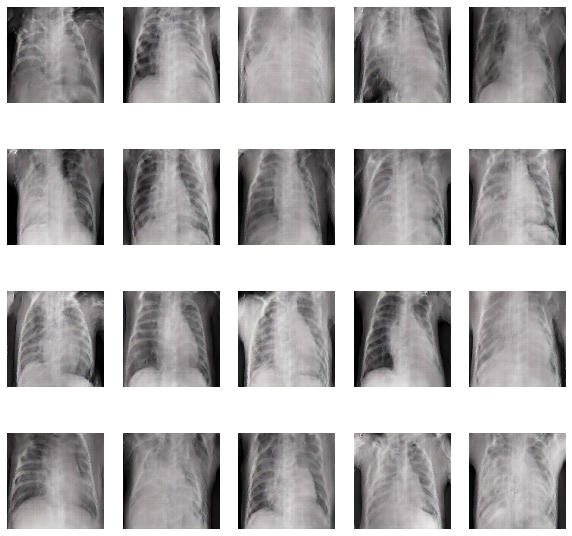

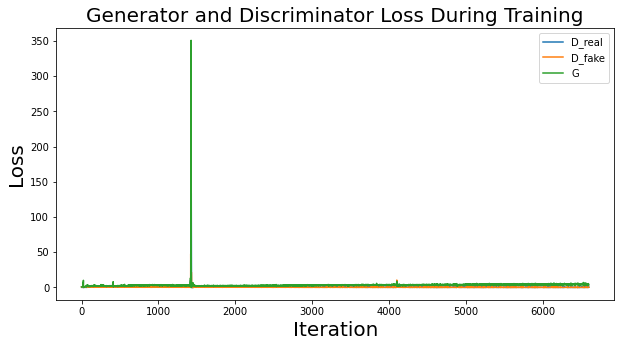

In [25]:
# train model 
train(generator, discriminator, gan, X_pneumonia, latent_dim, n_epochs=n_epoch, n_batch=batch_size)

In [26]:
fake_path2 = glob.glob('../content/image_at_epoch*.png')
fake_imgs = get_data(sorted(fake_path2), rand_shuffle=False)

Processing index 00000 of 00010 ==> 000%
Processing index 00001 of 00010 ==> 010%
Processing index 00002 of 00010 ==> 020%
Processing index 00003 of 00010 ==> 030%
Processing index 00004 of 00010 ==> 040%
Processing index 00005 of 00010 ==> 050%
Processing index 00006 of 00010 ==> 060%
Processing index 00007 of 00010 ==> 070%
Processing index 00008 of 00010 ==> 080%
Processing index 00009 of 00010 ==> 090%


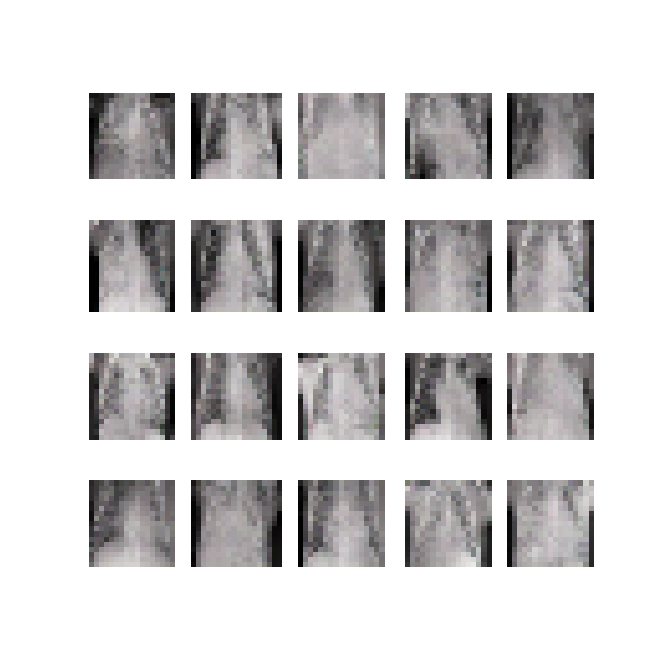

In [27]:
fake_transp = [np.transpose(fake_imgs[i,:,:]) for i in range(fake_imgs.shape[0])]

fig = plt.figure(figsize=(12,12)) 
plt.axis("off") 
imgs = [[plt.imshow(np.transpose(i,(2,1,0)), animated=True)] for i in fake_transp] 
ani = animation.ArtistAnimation(fig, imgs, interval=1000, repeat_delay=1000, blit=True) 

HTML(ani.to_jshtml())

## Create Gif

In [0]:
files = []
n_iter = int(n_epoch/10)
imgs_epochs = glob.glob('../content/image_at_epoch_*.png') 
for img_epoch in imgs_epochs: 
    files.append(imageio.imread(img_epoch)) 
imageio.mimsave('dcgan_celebA_generation_animation2.gif', files, fps=5) 

In [29]:
!ls 

dcgan_celebA_generation_animation2.gif	image_at_epoch_0120.png
drive					image_at_epoch_0140.png
image_at_epoch_0020.png			image_at_epoch_0160.png
image_at_epoch_0040.png			image_at_epoch_0180.png
image_at_epoch_0060.png			image_at_epoch_0200.png
image_at_epoch_0080.png			sample_data
image_at_epoch_0100.png


## Generated and save the images in a zipped file

In [0]:
# use the generator to generate n fake
def XRayFakeGenerator(g_model=generator, latent_dim =100, n_samples=100, show_gen=False):
    # generate points in latent space 
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs 
    X = g_model.predict(x_input)  
    
    # Show the generated images
    if show_gen and n_samples<=30: 
        ncols = 5
        nrows = int(n_samples/ncols)
        plt.figure(figsize=(12,10)) 
        for idx in range(nrows*ncols): 
            plt.subplot(nrows, ncols, idx+1)
            plt.imshow(X[idx,:,:]); plt.axis('off')
        plt.show();
    return X 

XRay_fake = XRayFakeGenerator(generator, n_samples=20)

In [0]:
# SAVE TO ZIP FILE 
import zipfile
output_path = zipfile.PyZipFile('../content/drive/My Drive/Colab Notebooks/XRayPneumoniaFake727.zip', mode='w')

XRay_generated = XRayFakeGenerator(n_samples=727)
for idx in range(XRay_generated.shape[0]):
    img_XRayFake  = XRay_generated[idx,:,:]
    name_XRayFake = 'XRay_generated {:04d}.png'.format(idx)
    imageio.imwrite(name_XRayFake, img_XRayFake)
    
    output_path.write(name_XRayFake)
    os.remove(name_XRayFake) 
output_path.close()